<a href="https://colab.research.google.com/github/jmarrietar/mineria-de-datos/blob/main/%5BProyecto%5D%20Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TO DO

* Improve and understand more `Naive Bayes` (class videos lot of information)


--------

# 1. Introducción  

En este Notebook se trabajará la clasificación de clientes pertenecientes a un periodo de tiempo determinado donde se intentará predecir si volverán a comprar en el próximo periodo (2 Meses). Y de esta forma clasificar los que volverán a comprar en los proximos 2 meses de los que posiblemente no. Para esto se utilizara el dataset proveniente de http://archive.ics.uci.edu/ml/datasets/Online+Retail





# 2. Desarrollo 

Se utilizará la librería `lifetimes` para extraer algunos features de interés.

In [201]:
!pip install --quiet lifetimes

In [202]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dateutil import parser, relativedelta
from sklearn import metrics, svm, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, average_precision_score, f1_score,
                             mean_squared_error, plot_precision_recall_curve,
                             precision_score, recall_score, roc_auc_score)
from sklearn.naive_bayes import GaussianNB

import gdown
import xgboost
from lifetimes.utils import summary_data_from_transaction_data
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline

In [203]:
!gdown https://drive.google.com/uc?id=1_AJd_FiQ6LSWSK4e__ccfLzhu_sWWNUS

Downloading...
From: https://drive.google.com/uc?id=1_AJd_FiQ6LSWSK4e__ccfLzhu_sWWNUS
To: /content/OnlineRetail.csv
45.6MB [00:00, 144MB/s] 


In [204]:
online_retail = pd.read_csv(
    "OnlineRetail.csv",
    sep=",",
    dtype={"CustomerID": "object"},
    encoding="unicode_escape",
)

In [205]:
online_retail["InvoiceDate"] = pd.to_datetime(online_retail["InvoiceDate"])

# Create an additional column for date as year and month
online_retail["date"] = online_retail["InvoiceDate"].dt.strftime("%Y-%m")

# Create a new column for the total expenditure of that product in the purchase.
online_retail["total_sales_amount"] = (
    online_retail["UnitPrice"] * online_retail["Quantity"]
)

In [206]:
# Add column for cancelations 
online_retail['cancelation'] = online_retail['InvoiceNo'].apply(lambda x: x.startswith("C"))
online_retail['cancelation'] = online_retail['total_sales_amount'] <0

In [207]:
# Only positive purchases (No cancelations)
online_retail_purchases = online_retail[online_retail['cancelation'] == False] 

Cómo se usarán particiones de tiempo se agruparan las compras de los usuarios por fechas.

In [208]:
transactional_purchases = (
    online_retail_purchases.groupby(["InvoiceNo", "CustomerID", "InvoiceDate"])[
        ["Quantity", "total_sales_amount"]
    ]
    .agg("sum")
    .reset_index()
)

In [209]:
transactional_purchases.head()

,InvoiceNo,CustomerID,InvoiceDate,Quantity,total_sales_amount
0,536365,17850,2010-12-01 08:26:00,40,139.12
1,536366,17850,2010-12-01 08:28:00,12,22.20
2,536367,13047,2010-12-01 08:34:00,83,278.73
3,536368,13047,2010-12-01 08:34:00,15,70.05
4,536369,13047,2010-12-01 08:35:00,3,17.85


# Clasificacion

Debido a que este problema se relaciona con **Time Aware Modeling**, donde el conjunto de validación se compone de observaciones de una ventana de tiempo fuera de (y más reciente que) la ventana de tiempo utilizada para el entrenamiento del modelo, la prueba se realiza en  un enfoque de validacion **Out-of-time validation (OTV).** 

Es decir, tomo data de un periodo anterior para crear mi dataset de entrenamiento y dejo un periodo de tiempo posterior para crear el dataset de validacion. 

![](https://drive.google.com/uc?export=view&id=12ncYfgu1s77BScvVHu_PKliSwioC8glr)    


Se crean varias funciones auxiliares que toman transacciones históricas como inputs y crean un conjunto de datos con Features de estadísticas básicas como número de compras del período pasado, actual y siguiente y monto gastado en período pasado, actual y siguiente. Así como el Recency y el frequency. 

In [210]:
def create_features_split(transactions, split_date, period_length, datetime_col, total_sales_col):
    """
    Taket historic transactional level data and returns train and test dataset in 
    custumer level useful to be used by machine learning models. 
    
    Arguments:
        transactions - Dataframe at transaction level with list of purchases.
        split_date - Date to be used to end train date
        period_length - The length of period in Months.
        datetime_col - Column of date time
        
    Returns:
        train - Dataframe at customer level to be used for training
        test - Dataframe at customer level to be used for testing 
        
    """

    train = transactions[transactions[datetime_col] < split_date]

    date = parser.parse(split_date)
    end_test_date = date + relativedelta.relativedelta(months=period_length)
    end_test_date = end_test_date.strftime("%Y-%m-%d")

    train_transactions = transactions[transactions[datetime_col] < split_date]
    test_transactions = transactions[transactions[datetime_col] < end_test_date]

    print("Creating Train ...")
    train = _transactions_to_dataset(
        train_transactions,
        split_date,
        period_length,
        "InvoiceDate",
        "CustomerID",
        total_sales_col,
    )

    print("Creating Test ...")
    test = _transactions_to_dataset(
        test_transactions,
        end_test_date,
        period_length,
        "InvoiceDate",
        "CustomerID",
        total_sales_col,
    )

    return train, test


def _transactions_to_dataset(
    transactions,
    end_date,
    period_length,
    datetime_col,
    customer_id_col,
    total_sales_col,
):
    """
    Take historic transactions and create a dataset with basics staticts features,
    number of purchases from past, current and next period and amount spent from 
    past, current and next period.
    
    Begining dataset: t0
    Past period: t1 - t2
    Current period: t2 - t3
    Target period: t3 - t4
    
    Arguments: 
        transactions - Dataframe at transaction level with war list of purchases.
        end_date - Last date to use to create dataset
        period_length - The length of period in Months.
        customer_id_col - Name of column with the ids of costumers
        total_sales_col - Name of column of the total amount spent in purchase
    
    Returns: 
        dataset - Data for customer level with number of transactions and total 
                    amount spent in the last, current and next period
    
    """

    t4 = end_date
    t3 = (
        parser.parse(t4) - relativedelta.relativedelta(months=period_length)
    ).strftime("%Y-%m-%d")
    t2 = (
        parser.parse(t3) - relativedelta.relativedelta(months=period_length)
    ).strftime("%Y-%m-%d")
    t1 = (
        parser.parse(t2) - relativedelta.relativedelta(months=period_length)
    ).strftime("%Y-%m-%d")
    t0 = transactions[datetime_col].min().strftime("%Y-%m-%d")

    # Define time periods
    transactions_dev = transactions[transactions[datetime_col] < t3]

    current_period = transactions_dev[
        (transactions_dev[datetime_col] >= t2) & (transactions_dev[datetime_col] < t3)
    ]

    past_period = transactions_dev[
        (transactions_dev[datetime_col] >= t1) & (transactions_dev[datetime_col] < t2)
    ]

    target_period = transactions[
        (transactions[datetime_col] >= t3) & (transactions[datetime_col] < t4)
    ]

    # Basic Features (Frequency, Recency and T) since t0
    features_train = summary_data_from_transaction_data(
        transactions_dev,
        customer_id_col=customer_id_col,
        datetime_col=datetime_col,
        monetary_value_col=total_sales_col,
        freq="D",
    )
    features_train.reset_index(level=0, inplace=True)

    # Purchases by customers current period
    purchases_current_period = (
        current_period[customer_id_col]
        .value_counts()
        .rename_axis(customer_id_col)
        .to_frame("purchases_current_period")
    )
    purchases_current_period.reset_index(level=0, inplace=True)

    # Purchases by customer past period
    purchases_past_period = (
        past_period[customer_id_col]
        .value_counts()
        .rename_axis(customer_id_col)
        .to_frame("purchases_past_period")
    )

    purchases_past_period.reset_index(level=0, inplace=True)

    # Amount spent by customer current period
    amount_spent_current_period = (
        current_period.groupby([customer_id_col])[[total_sales_col]]
        .agg("sum")
        .reset_index()
        .rename(columns={"total_sales_amount": "amount_spent_current_period"})
    )

    # Amount spent by customer last period
    amount_spent_past_period = (
        past_period.groupby([customer_id_col])[[total_sales_col]]
        .agg("sum")
        .reset_index()
        .rename(columns={"total_sales_amount": "amount_spent_past_period"})
    )

    # Create Targets
    purchases_target = (
        target_period[customer_id_col]
        .value_counts()
        .rename_axis(customer_id_col)
        .to_frame("purchases_next_period")
    )

    amount_spent_target = (
        target_period.groupby([customer_id_col])[[total_sales_col]]
        .agg("sum")
        .reset_index()
        .rename(columns={total_sales_col: "amount_spent_next_period"})
    )

    # Join the Datasets
    dataset = pd.merge(
        features_train, purchases_past_period, on=customer_id_col, how="left"
    )
    dataset = pd.merge(
        dataset, purchases_current_period, on=customer_id_col, how="left"
    )
    dataset = pd.merge(dataset, purchases_target, on=customer_id_col, how="left")
    dataset = pd.merge(
        dataset, amount_spent_past_period, on=customer_id_col, how="left"
    )
    dataset = pd.merge(
        dataset, amount_spent_current_period, on=customer_id_col, how="left"
    )
    dataset = pd.merge(dataset, amount_spent_target, on=customer_id_col, how="left")

    # Fill NA (No sales) with 0
    dataset["purchases_past_period"].fillna(0, inplace=True)
    dataset["purchases_current_period"].fillna(0, inplace=True)
    dataset["purchases_next_period"].fillna(0, inplace=True)
    dataset["amount_spent_past_period"].fillna(0, inplace=True)
    dataset["amount_spent_current_period"].fillna(0, inplace=True)
    dataset["amount_spent_next_period"].fillna(0, inplace=True)

    print("Data statistics starts from {}".format(t0))
    print("Past period from [{} to {})".format(t1, t2))
    print("Current period from [{} to {})".format(t2, t3))
    print("Next period from [{} to {})".format(t3, t4))

    return dataset

def calculate_metrics(y_test, predictions_proba, predictions):

	fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_proba)
	print("AUC {:0.3f}".format(metrics.auc(fpr, tpr)))

	# F1 score
	f1 = f1_score(y_test, predictions)
	print("F1 score: {0:0.3f}".format(f1))

	# Precision score
	precision = precision_score(y_test, predictions)
	print("Precision score: {0:0.3f}".format(precision))

	# Recall score
	recall = recall_score(y_test, predictions)
	print("Recall score: {0:0.3f}".format(recall))

	# Average Precision-Recall
	average_precision = average_precision_score(y_test, predictions_proba)
	print("Average precision-recall score: {0:0.3f}".format(average_precision))

	fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_proba, pos_label=1)
	cm = metrics.confusion_matrix(y_test, predictions)
	auc = roc_auc_score(y_test, predictions_proba)
	print("AUC: %.3f" % auc)
	print("Accuracy: {}".format(accuracy_score(y_test, predictions)))

	# Plot ROC curve
	lw = 2
	sns.set_style({"axes.grid": False})
	sns.set_style("darkgrid")
	ax1 = sns.lineplot(fpr, tpr, color="darkorange", lw=lw, label="AUC = %0.2f" % auc)
	plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
	ax1.set_title("Receiver operating characteristic")
	ax1.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
	plt.legend(loc="lower right")
	plt.show()

	# Plot Confusion Matrix
	fig, ax2 = plot_confusion_matrix(conf_mat=cm, show_normed=False)
	plt.show()

	disp = plot_precision_recall_curve(model, X_test, y_test)
	disp.ax_.set_title(
	    "2-class Precision-Recall curve: " "AP={0:0.2f}".format(average_precision)
	)

In [211]:
# Configurable experimental variables 
SPLIT_DATE = "2011-05-01" # [CHANGE ACCORDINGLY] Date to be used to end train date 
PERIOD_LENGTH = 2 # Months

In [212]:
train, test = create_features_split(
    transactional_purchases,
    split_date=SPLIT_DATE,
    period_length=PERIOD_LENGTH,
    datetime_col="InvoiceDate",
    total_sales_col="total_sales_amount"
)

Creating Train ...
Data statistics starts from 2010-12-01
Past period from [2010-11-01 to 2011-01-01)
Current period from [2011-01-01 to 2011-03-01)
Next period from [2011-03-01 to 2011-05-01)
Creating Test ...
Data statistics starts from 2010-12-01
Past period from [2011-01-01 to 2011-03-01)
Current period from [2011-03-01 to 2011-05-01)
Next period from [2011-05-01 to 2011-07-01)


* **Frequency:** Representa el número de compras repetidas que ha realizado el cliente. 

* **Recency:** representa la edad del cliente cuando realizó sus compras más recientes. ** Esto es igual a la duración entre la primera compra de un cliente y su última compra. ** (Por lo tanto, si solo ha realizado una compra, la antigüedad es 0).

* **T:** representa la edad del cliente en las unidades de tiempo elegidas. ** Esto es igual a la duración entre la primera compra de un cliente y el final del período en estudio. **

* **monetary_value** representa el valor medio de las compras de un cliente determinado. Esto es igual a la suma de todas las compras de un cliente dividida por el número total de compras.

* **purchases_past_period**: La cantidad de compras en el periodo anterior. 

* **purchases_current_period:** La cantidad de compras en el periodo actual. 

* **amount_spent_past_period:** La cantidad de dinero gastado en el periodo anterior.

* **amount_spent_current_period:** La cantidad de dinero gastado en el periodo actual. 


In [213]:
feature_cols = ['frequency', 'recency', 'T', 'monetary_value',
       'purchases_past_period', 'amount_spent_past_period', 
       'purchases_current_period','amount_spent_current_period']

y_col = ['buy_next_period']

In [214]:
# create new column based on `amount_spent_next_period`
train['buy_next_period'] = np.where(train['amount_spent_next_period'] > 0, 1, 0)
test['buy_next_period'] = np.where(test['amount_spent_next_period'] > 0, 1, 0)

X_train = train[feature_cols]
y_train = train[y_col]

X_test = test[feature_cols]
y_test = test[y_col]

In [215]:
train[feature_cols+y_col].head()

,frequency,recency,T,monetary_value,purchases_past_period,amount_spent_past_period,purchases_current_period,amount_spent_current_period,buy_next_period
0,0.0,0.0,41.0,0.00,0.0,0.00,1.0,77183.60,0
1,1.0,50.0,83.0,475.39,1.0,711.79,1.0,475.39,1
2,1.0,40.0,74.0,227.44,1.0,892.80,1.0,227.44,1
3,0.0,0.0,26.0,0.00,0.0,0.00,1.0,334.40,0
4,0.0,0.0,12.0,0.00,0.0,0.00,1.0,296.50,1


# [Optional] Pre-processing

In [216]:
#from sklearn.preprocessing import StandardScaler, RobustScaler

In [217]:
#X_train[feature_cols].head()

In [218]:
"""
# Fit Standard Scalers in X_train
scalers = {}
for feature in feature_cols:
    scaler = RobustScaler()
    scaler.fit(X_train[[feature]])
    scalers[feature] = scaler
    X_train[feature] = scaler.transform(X_train[[feature]])
"""

'\n# Fit Standard Scalers in X_train\nscalers = {}\nfor feature in feature_cols:\n    scaler = RobustScaler()\n    scaler.fit(X_train[[feature]])\n    scalers[feature] = scaler\n    X_train[feature] = scaler.transform(X_train[[feature]])\n'

In [219]:
"""
# Apply Standard scalers to X_test
for feature in feature_cols:
    scaler = scalers[feature]
    X_test[feature] = scaler.transform(X_test[[feature]])
"""

'\n# Apply Standard scalers to X_test\nfor feature in feature_cols:\n    scaler = scalers[feature]\n    X_test[feature] = scaler.transform(X_test[[feature]])\n'

# Clasificadores
**Goal:** Predecir si el cliente comprará en el próximo período. 

### **Naive Bayes**

In [166]:
model = GaussianNB()

In [86]:
# Train model
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

In [87]:
# Predictions for test data
predictions_proba = model.predict_proba(X_test)[:, 1]
predictions = model.predict(X_test)

AUC 0.71
F1 score: 0.58
Precision score: 0.70
Recall score: 0.50
Average precision-recall score: 0.70
AUC: 0.708
Accuracy: 0.6721446179129006


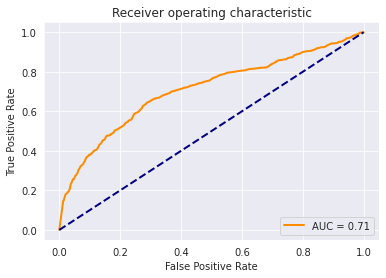

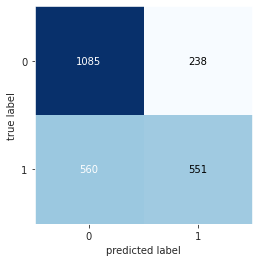

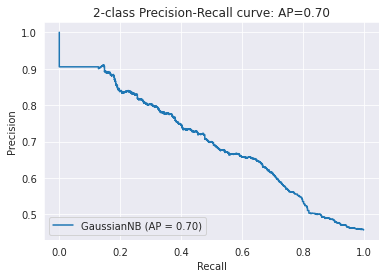

In [88]:
# Calculate all metrics and Plots
calculate_metrics(y_test, predictions_proba, predictions)

### **Decision Tree**

In [167]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [168]:
model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [169]:
# Train model
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [170]:
# Predictions for test data
predictions_proba = model.predict_proba(X_test)[:, 1]
predictions = model.predict(X_test)

AUC 0.70
F1 score: 0.58
Precision score: 0.71
Recall score: 0.49
Average precision-recall score: 0.64
AUC: 0.696
Accuracy: 0.6783073130649138


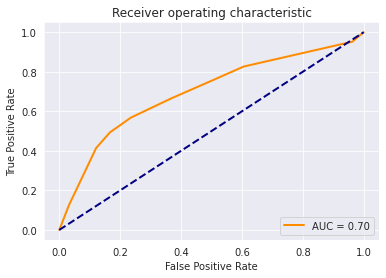

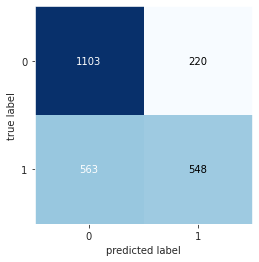

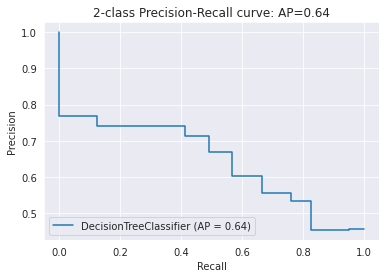

In [171]:
# Calculate all metrics and Plots
calculate_metrics(y_test, predictions_proba, predictions)

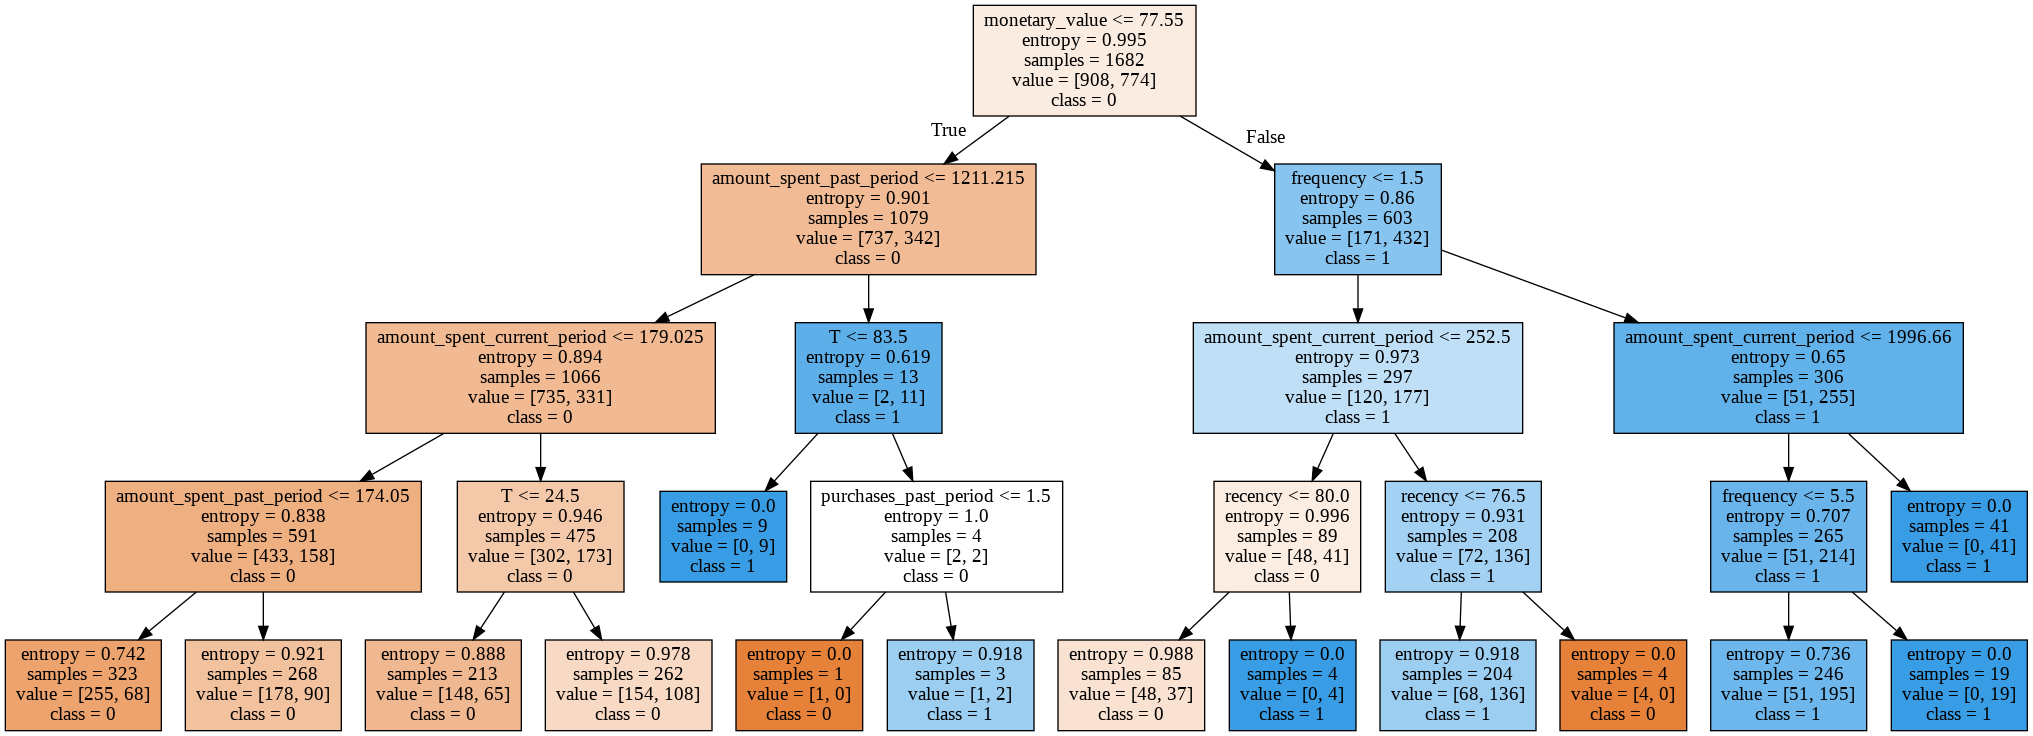

In [172]:
import pydotplus
from IPython.display import Image
dot_data = tree.export_graphviz(
    model,
feature_names=X_train.columns, class_names=["0", "1"], filled=True,
out_file=None,
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

###**Random Forest**

In [190]:
model = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=20, criterion='entropy')

In [191]:
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

AUC 0.73
F1 score: 0.62
Precision score: 0.71
Recall score: 0.55
Average precision-recall score: 0.73
AUC: 0.732
Accuracy: 0.6935086277732129


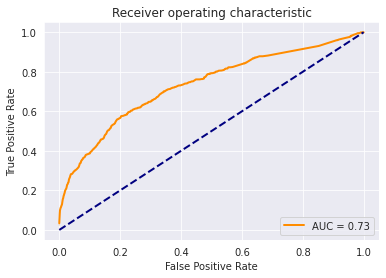

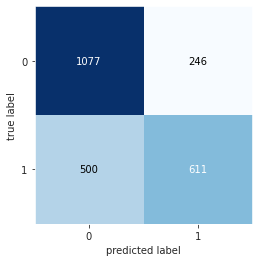

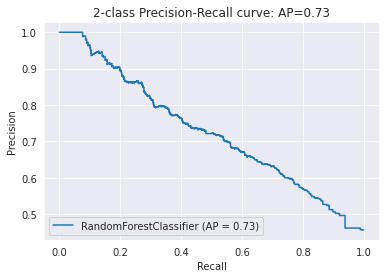

In [192]:
# Calculate all metrics and Plots
calculate_metrics(y_test, predictions_proba, predictions)

#### Feature Ranking 

In [194]:
import time
from sklearn.inspection import permutation_importance

In [196]:
feature_names = [f'feature {i}' for i in range(X_train.shape[1])]

In [198]:
feature_names = X_train.columns

In [199]:
start_time = time.time()
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 0.596 seconds


**TO DO:**
    - Hacerle un Double check a esto y aque intuitivamente esperaria que 

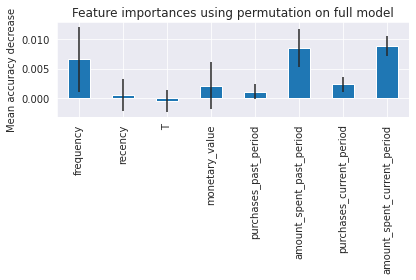

In [200]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### **Gradient Boosting** (XGBoost)

In [220]:
from matplotlib import pyplot
from xgboost import plot_importance

In [221]:
model = xgboost.XGBClassifier(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.08,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=20,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [222]:
# Train model
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.08, max_delta_step=0, max_depth=4,
              min_child_weight=1.5, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.6, verbosity=1)

In [223]:
# make predictions for test data
predictions_proba = model.predict_proba(X_test)[:,1]
predictions = model.predict(X_test)

AUC 0.732
F1 score: 0.621
Precision score: 0.713
Recall score: 0.550
Average precision-recall score: 0.727
AUC: 0.732
Accuracy: 0.6935086277732129


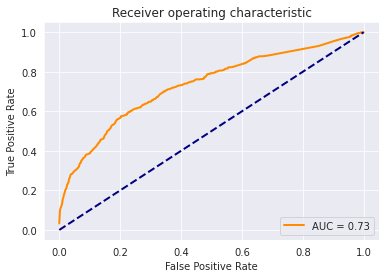

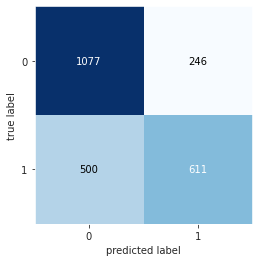

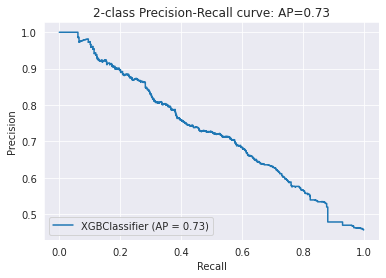

In [224]:
# Calculate all metrics and Plots
calculate_metrics(y_test, predictions_proba, predictions)

#### Feature Ranking 

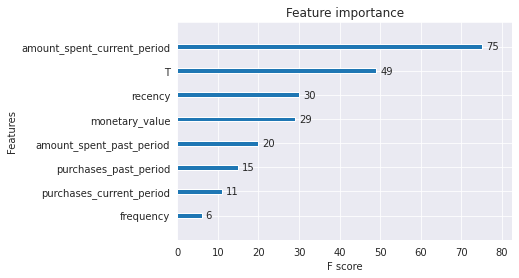

In [227]:
plot_importance(model)
pyplot.show()

In [ ]:
"""
TO DO: 
 - Hacer Hyper Parameters Search 
"""

### **Support Vectore Machine (SVM)**

In [ ]:
model = svm.SVC(probability=True)

In [ ]:
# Train model
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

AUC 0.73
F1 score: 0.61
Precision score: 0.70
Recall score: 0.54
Average precision-recall score: 0.73
AUC: 0.732
Accuracy: 0.6869350862777321


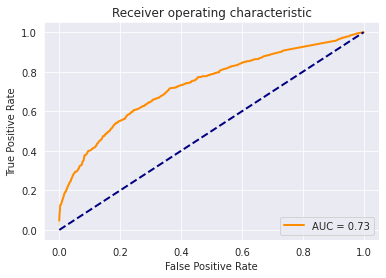

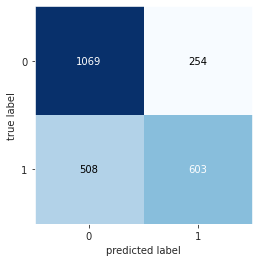

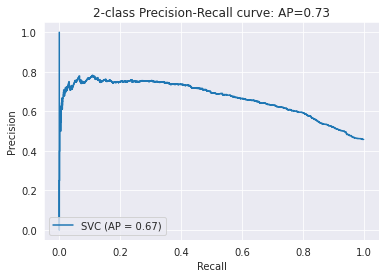

In [ ]:
# Calculate all metrics and Plots
calculate_metrics(y_test, predictions_proba, predictions)